# Invariance check
This notebook loads the architectures :
- baseline
- invariant

And check that the invariant is really invariant under the dihedral transformation of the input

In [1]:
import tensorflow as tf
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
%matplotlib inline

Declare utility functions to load the architectures

In [2]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path, bands):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture(bands=bands)
    return g, nn

In the next cell, the achitectures are loaded and the NN graph is built

In [3]:
graph_baseline, nn_baseline = load_arch("arch_baseline.py", 3)
graph_invariant, nn_invariant = load_arch("arch_invariant.py", 3)

Then two session are created. A session contain the values of the variables of a graph.

In [4]:
sess_baseline = tf.Session(graph=graph_baseline)
sess_invariant = tf.Session(graph=graph_invariant)

Now all the variables of the sessions are initialized according to how they where created (see arch code).

In [5]:
sess_baseline.run(tf.variables_initializer(graph_baseline.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))
sess_invariant.run(tf.variables_initializer(graph_invariant.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))

An image is randomly created to make the test

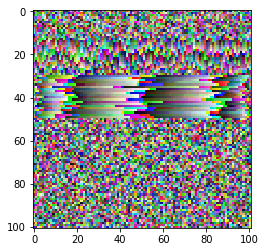

In [6]:
x = np.random.normal(size=(101, 101, 3))
x[10:30, :, :] = np.sort(x[10:30, :, :], 0)
x[30:50, :, :] = np.sort(x[30:50, :, :], 1)
x[50:, :, :] = np.sort(x[50:, :, :], 2)
plt.imshow(x)

The following function can apply all the transformation of the dihedral group on an image (for i = 0 to 7)

In [7]:
def dihedral(x, i):
    x = x.copy()
    if i & 4:
        x = np.transpose(x, (1, 0, 2))  # tau[4]
    if i & 1:
        x = x[:, ::-1, :]  # tau[1]
    if i & 2:
        x = x[::-1, :, :]  # tau[2]
    return x

The image x is transformed in all the different manner with the previous function

In [8]:
xs = np.array([dihedral(x, i) for i in range(8)])

The architecture baseline, at least when it is not trained, is not expected to give the same result for all the xs.

[ 0.63690341  0.87366682  0.57853985  0.81580043  0.75548238  0.52806133
  0.72841161  0.5453431 ]


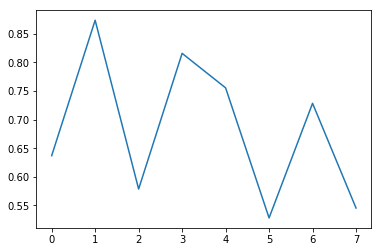

In [9]:
ps_baseline = sess_baseline.run(nn_baseline.tfp, feed_dict={nn_baseline.tfx: xs})
plt.plot(ps_baseline)
print(ps_baseline)

On the other hand, the invariant architecture is expected to give the same result up to rounding error

[ 0.21371588  0.21371567  0.21371531  0.21371596  0.21371487  0.21371466
  0.21371627  0.21371491]


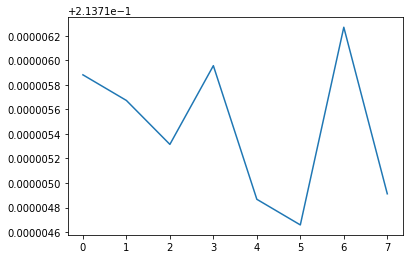

In [10]:
ps_invariant = sess_invariant.run(nn_invariant.tfp, feed_dict={nn_invariant.tfx: xs})
plt.plot(ps_invariant)
print(ps_invariant)

Furthermore, the regular representation of the intermediate tensor can be obseved. (nn_invariant.test is a tensor close to the end of the graph, see the code)

In [11]:
test = sess_invariant.run(nn_invariant.test, feed_dict={nn_invariant.tfx: xs})
test = np.reshape(test, (8, 8, -1))

The following graph shows the value of the test tensor for the different transformation of the image

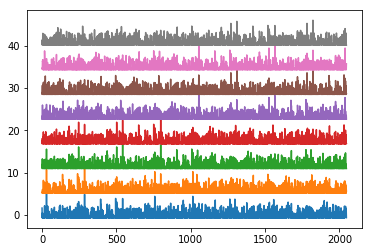

In [12]:
step = test[0].max() - test[0].min()
for i in range(8):
    plt.plot(test[i].flatten() + step * i)

Up to a specific permutation that can be obtained with the help of the mutiplication table of the group, the test tensor is expected to not depend on the transformation of the input image.

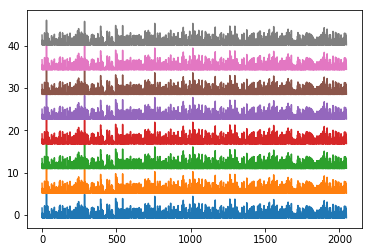

In [13]:
mt = np.array([ [0, 1, 2, 3, 4, 5, 6, 7], [1, 0, 3, 2, 5, 4, 7, 6],
                [2, 3, 0, 1, 6, 7, 4, 5], [3, 2, 1, 0, 7, 6, 5, 4],
                [4, 6, 5, 7, 0, 2, 1, 3], [5, 7, 4, 6, 1, 3, 0, 2],
                [6, 4, 7, 5, 2, 0, 3, 1], [7, 5, 6, 4, 3, 1, 2, 0]])
# tau[mt[a,b]] = tau[a] o tau[b]

iv = np.array([0, 1, 2, 3, 4, 6, 5, 7])
# tau[iv[a]] is the inverse of tau[a]

for i in range(8):
    plt.plot(test[i][mt[i]].flatten() + step * i)